In [1]:
%pylab inline

from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
display(HTML(open('Notebook.css').read()))  #load the CCS style sheet


<center> <h1> STOCHASTIC DECAY </h1> </center>

<div style="text-align: right;">André van Schaik<br>May 2015; January 2016</div>

This notebook reports on a method of implementing long time constants in hardware using state-variables encoded with a limited number of bits. This situation occurs, for example, when simulating a neural network with many millions of neurons using time multiplexing on a **Field Programmable Gate Array** (FPGA). With a standard **Infinite Impulse Response** (IIR) filter approach, a large number of bits would be needed for each state variable to give each the resolution to calculate long time constants. But each state variable would need to be stored in memory, which is limited on an FPGA and which introduces a communication bottleneck, since only a few bits can be exchanged with the memory in a single clock cycle.

# Discrete time filtering

In the standard discrete time filtering approach, the continuous time equation is discretised:

$$\begin{align*} 
\frac{\mathrm d V}{\mathrm d t} &= -\frac{V}{\tau} \\
V &= -\tau \frac{\mathrm d V}{\mathrm d t}\\
V[t+1] &= -\tau \frac{V[t+1] - V[t]}{\mathrm \Delta t} \\
V[t+1] (1 + \frac{\tau}{\Delta t}) &= \frac{\tau}{\Delta t}V[t] \\
V[t+1] &= \frac{\frac{\tau}{\Delta t}}{1 + \frac{\tau}{\Delta t}}V[t] \\
V[t+1] &= \frac{\tau}{\Delta t + \tau}V[t] \\
\end{align*}$$

If $\tau$, the time constant, is expressed in clock cycles, then $\Delta t = 1$, so the equation becomes:

$$V[t+1] = a \times V[t]$$
where
$$a = \frac{\tau}{\tau+1}$$

The decrement in $V$ is thus given by:

$$d = V[t] - V[t+1] = \frac{V[t]}{\tau+1}$$


When $\tau$ is large, $a$ is only a little less than 1, and a large number of bits are needed to encode its value accurately. If the number of bits used to encode $V$ is equal to, or less than, the number of bits used to encode $a$, the above recursive multiplication just results in a near linear decay. This is shown below for $V$ encoded with 6 bits:

*(Pablo)* $r$ here is used just to emulate a certain number of bits, but proportional to the ratio $\tau/(\tau+1)$. 
This is done because the FPGA only works with binary numbers when representing floating point numbers. Also note that they are not refering to the number of bits in a variable type, but to the actual number of bits necessary to write numbers in binary.

a=972_10
a=0b1111001100_2
V=15_10
V=0b1111_2


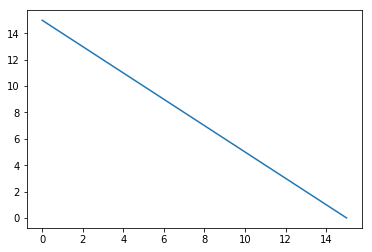

In [3]:
# using integers only mimics using a limited number of bits
nbits = 10
r = 2**nbits

tau = 19
a = (tau*r)/(tau+1)

V = 15
Vout = V
print "a=" + str(a) + "_10"
print "a=" + str(bin(a)) + "_2"
print "V=" + str(V) + "_10"
print "V=" + str(bin(V)) + "_2"
while V>0:
    V = a*V/r
    Vout = append(Vout,V)
    
plot(Vout);

Thus, to approximate an exponential decay, the number of bits in $V$ would need to be large too. Here both $a$ and $V$ are encoded using 10 bits:

a=972_10
a=0b1111001100_2
V=1023_10
V=0b1111111111_2


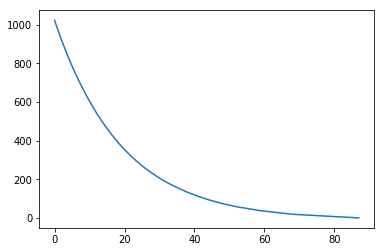

In [4]:
# using integers only mimics using a limited number of bits
nbits = 10
r = 2**nbits

tau = 19
a = (tau*r)/(tau+1)

V = 1023
Vout = V
print "a=" + str(a) + "_10"
print "a=" + str(bin(a)) + "_2"
print "V=" + str(V) + "_10"
print "V=" + str(bin(V)) + "_2"
while V>0:
    V = a*V/r
    Vout = append(Vout,V)
    
plot(Vout);

(_Pablo_) Note how it looks like a linear decay by the end of it. This is also expressed by $V[t]$, i.e. the larger it is, the larger the decay

In our FPGA implementation we implement a massive number of time constants (for neurons and synapses) through the use of time multiplexing. This means that at each clock cycle we need to store the current state variable in memory and read the next one from memory. This communication bandwidth quickly becomes the bottleneck, and it is important to keep the number of bits per state variable small.

# Radioactive Decay

Instead of deterministically performing the multiplications with a variable just less than one, we can stochastically decay the state. Imagine we have $V$ particles, each with a small probability of decaying in each timestep give by $1/(\tau+1)$. This is for instance the case in radioactive decay, which is also an exponential decaying process. 

We can implement this by drawing $V(t-1)$ random numbers $X$, uniformly distributed in the interval $[0,1)$, one for each 'particle', and decaying those particles for which $X \ge a$. The new $V(t)$ is then the sum of the remaining active particles. This implementation is given below using only 10 bits to encode V, for 1023 different stochastic traces:

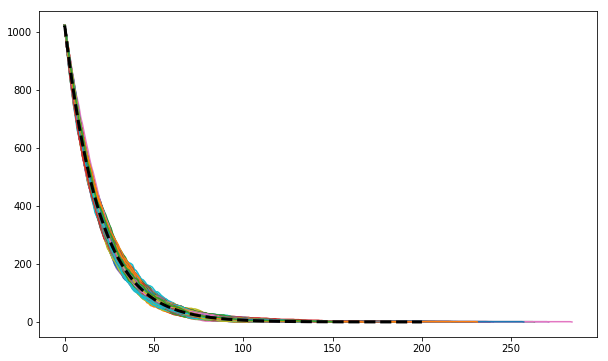

In [5]:
def dec2bin (N_bits,number):
    return fromiter((a for a in binary_repr(int(number),N_bits)), dtype=int_)[::-1]

def bin2dec (N_bits,number):
    return dot(number,fromiter((2**x for x in range(N_bits)), dtype=int_))

def stochastic_decay_ra(V_init = 1023, tau = 19, bits = 10):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    V_bin = dec2bin(bits,V_init)                # convert to binary
    V_int = V_init                              # reset initial voltage (Pablo: think of it as n of particles)
    Vs = V_int                                  # store V_int in trace for plotting
    t = 0                                       # initialise decay time counter

    while ( V_int > 0 ):                        # decay full trace for this seed
        V_int = bin2dec(bits, V_bin)            # convert binary stored state to integer
        r = rand(V_int)                         # generate V_int random numbers uniform in [0,1)
        d = sum(r>=a)                           # determine how many should decay
        V_int -= d                              # decrement V_int
        V_bin = dec2bin(bits ,V_int)            # convert back to binary (4 bits)
        Vs = append(Vs,V_int)                   # append V_int to trace
        t += 1                                  # increment decay time counter

    return Vs, t                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)

V_init = 1023
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
bits = 10
T_ra = []                                       # empty array to store decay times
for i in range(1,1024):                      
    (Vs,t) = stochastic_decay_ra(V_init, tau, bits)
    T_ra = append(T_ra,t)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=3, label='IIR');       # plot IIR trace (once)


If we zoom in on a section of this graph, we see the stochastic traces are close to the deterministic IIR trace.

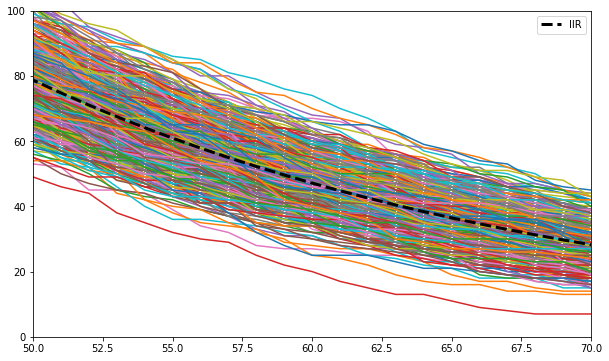

In [7]:
ax.set_xlim((50,70))
ax.set_ylim((00,100))
ax.legend()
display(fig)
fig.savefig("fig1.png", bbox_inches="tight", pad_inches=0.01)

# Distribution of survival times

The time taken to decay from an initial number of particles $N$ to $0$ particles is now a random variable. The distribution of this survival time can be calculated as follows.

Given the average decay is an exponential, each particle has a probability of not decaying (surviving) up to time $t$ of:

$$ P_s(t) = e^{-\lambda t} $$
with
$$\lambda = \frac{1}{\tau+1}$$

and thus of decaying before $t$:

$$ P_d(t) = 1 - e^{-\lambda t} $$

For the last particle to decay at time $t$ (equivalent to $V$ reaching $0$), we need all but 1 particle to decay at any time before, and the last one to decay at exactly $t$. The first term is simply given by:

$$ P_{d,N-1}(t) = \left(1 - e^{-\lambda t}\right)^{N-1} $$

The probability of the final particle decaying at exactly time $t$, is the probability of it surviving up to time $t-1$ multiplied by the probability of it decaying in one timestep:

$$\begin{align*}
P(t) &= e^{-\lambda (t-1)} (1 - e^{-\lambda 1})\\
&= e^{-\lambda t} (e^{\lambda} - 1)\\
&\approx \lambda e^{-\lambda t}
\end{align*}$$

Finally, since each of the $N = V$ initial particles can be the last one to decay, we get the distribution for the decay to zero as:

$$ P_{0}(t|N) = N \left(1 - e^{-\lambda t}\right)^{N-1} \lambda e^{-\lambda t}$$

A more exact derivation for our software implementation uses the fact that the decay of each particle follows a Bernoulli distribution, instead of an exponential distribution. The probability of decaying in one timestep is given by:

$$ P = \lambda $$

so that the probability of not decaying by time $t$ is:

$$ P_s(t) = (1 - \lambda)^t $$

Following the same steps as above results in the distribution:

$$ P_{0}(t|N) = N \left(1 - (1 - \lambda)^t\right)^{N-1} \lambda (1 - \lambda)^{t-1}$$

For $\lambda$ close to $0$ ($\tau$ is large), you'd expect the two distributions to be very similar since $e^{-\lambda} \approx 1 - \lambda$ according to a first order Taylor expansion.

Both versions are shown below together with the normalised histogram of simulated decay to zero times.


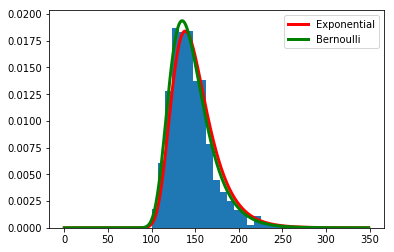

In [8]:
(n, bins, _) = hist(T_ra, bins=20, density=True)

t = arange(350)
mu = t/(tau+1.0)
p = 1/(tau+1.0)
N = V_init
P = N*(1-exp(-mu))**(N-1)*exp(-mu)*p
plot(t,P, 'r', linewidth=3, label="Exponential")

P = N*(1-(1-p)**t)**(N-1)*p*(1-p)**(t-1)
plot(t,P, 'g', linewidth=3, label="Bernoulli")
legend();

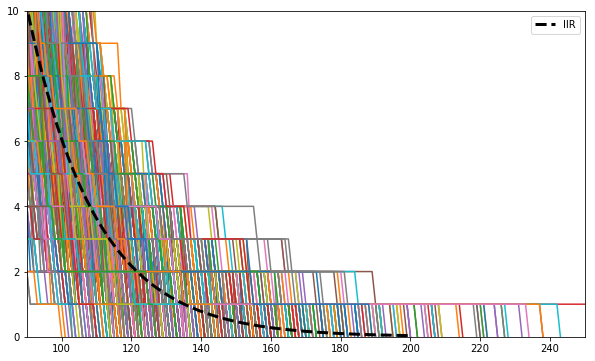

In [9]:
ax.set_xlim((90,250))
ax.set_ylim((00,10))
ax.legend()
display(fig)
fig.savefig("fig2.png", bbox_inches="tight", pad_inches=0.01)

# Single Bernouilli trials

(_Pablo_): We do this now so we can have one decay at a time.

The implementation analogous to radioactive decay needs the drawing of a random number for each particle independently at each time step. This is rather expensive to implement. If instead, at each clock cycle, $V$ is decremented by 1 according to a Bernouilli trial with a probability $p = V/(\tau+1)$ (for $V < \tau+1$), the number of cycles $n$ it takes for $V$ to decrement is given by the Geometric distribution:

$$ P(n) = (1-p)^{n-1}p $$

The expected value for $n$ to decrement 1 level is then given by:

$$ E(n) = \frac{1}{p} = \frac{\tau+1}{V} $$

The code below compares an IIR filter with floating point resolution with a stochastic decay where $V$ is stored using only 4 bits.

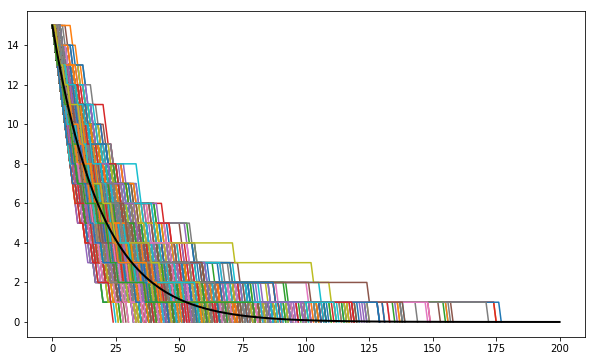

In [10]:
def stochastic_decay(V_init = 15, tau = 19, bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)
    
    # initialisation
    V_bin = dec2bin(bits,V_init)                # convert to binary
    V_int = V_init                              # reset initial voltage
    Vs = V_int                                  # store V_int in trace for plotting
    
    while ( V_int > 0 ):                        # decay full trace for this seed
        V_int = bin2dec(bits, V_bin)            # convert binary stored state to integer
        V_int -= rand() < V_int/(tau + 1.0)     # decrement based on random value
        V_bin = dec2bin(bits ,V_int)            # convert back to binary (4 bits)
        Vs = append(Vs,V_int)                   # append V_int to trace

    return Vs                                


fig = figure()
fig.set_size_inches(10,6)

V_init = 15                                     # initial value
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
bits = 4                                        # number of bits to store
for i in range(1,1024):                         # simulate multiple independent traces
    Vs = stochastic_decay(V_init, tau, bits)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k', linewidth=2);                      # plot IIR trace (once)



The figure above shows the deterministic IIR trace in black, and 1023 stochastic decay traces in various colours. Each of the 1023 traces is different, but the average decay is the same as for the IIR case.

# Extension to $V > \tau$

(_Pablo_): In the $p>1$ case, the decay is linear and this is not what we want. We can deal with that by dividing the decay in a deterministic and stochastic part.

When $V > \tau$ (i.e., $V \geq \tau+1$), we get $p > 1$, which is then not a probability anymore. However, one can simply decay $V$ by the integer part of $V/(\tau + 1)$, and use the remainder as $p$. Then, at each time step we have the following decay, $d$:

$$ d = \frac{V}{\tau+1} \approx int(\frac{V}{\tau+1}) + X $$

$$ P(X=1) = (\frac{V}{\tau+1})\%1 $$

where $x\%1$ is $x$ modulo 1, and $int(V/(\tau+1))$ is the integer part of $V/(\tau+1)$.

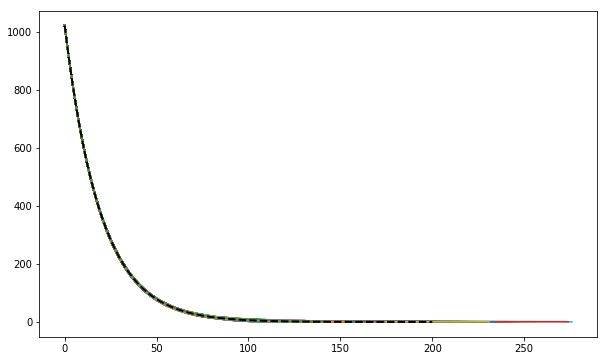

In [11]:
def stochastic_decay(V_init = 15, tau = 19, bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)

    # initialisation
    V_bin = dec2bin(bits,V_init)                # convert to binary
    V_int = V_init                              # reset initial voltage
    Vs = V_int                                  # store V_int in trace for plotting
    t = 0                                       # initialise decay time counter

    while ( V_int > 0 ):                        # decay full trace for this seed
        V_int = bin2dec(bits, V_bin)            # convert binary stored state to integer
        d = V_int/(tau+1.0)                     # calculate amount to decay
        V_int -= int(d)                         # deterministic part of decrement
        V_int -= rand()<(d%1)                   # stochastic part of decrement
        V_bin = dec2bin(bits ,V_int)            # convert back to binary (4 bits)
        Vs = append(Vs,V_int)                   # append V_int to trace
        t += 1                                  # increment decay time counter

    return Vs, t                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)


V_init = 1023                                   # initial value
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.)                                # IIR multiplication constant
bits = 10
Ts = []
for i in range(1,1024):                         # simulate multiple independent traces
    (Vs,t) = stochastic_decay(V_init, tau, bits)
    Ts = append(Ts,t)

    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

plot(Vd,'k--', linewidth=2, label='IIR');       # plot IIR trace (once)



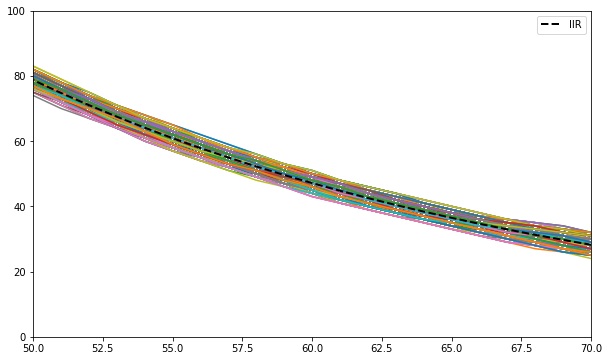

In [12]:
ax.set_xlim((50,70))
ax.set_ylim((0,100))
ax.legend()
display(fig)

In this implementation, the stochastic part affects at most a single decrement at each time step, while for $V > \tau$ some of the decrement is deterministic. In the radioactive decay version, all particles can independently decay (or not) at each time step. You would thus expect the radioactive decay version to show increased variance. Indeed comparing the figure above, with a copy of the radioactive decay one for the same settings clearly shows this:  
<img align="left" src="fig1.png">

# Distribution of survival times

In our stochastic decay, we now no longer have multiple particles decaying independently in parallel. Instead, the survival time is now the sum of N random variables, each the result of a sequence of Bernoulli trials, but with a different probability for decay. The probability distribution of a sum of random variables is the convolution of their individual probability distributions. If we start with $V = 2$, then we have two independent decay events, the first from $V = 2$ to $V = 1$ with intensity $\lambda_2 = 2/(\tau+1)$, and the second from $V = 1$ to $V = 0$ with intensity $\lambda_1 = 1/(\tau+1)$. Thus, we can write for the probabilities to decay at a particular time $t$:

$$ f_1(t_1) = \lambda_1 e^{-\lambda_1 t_1} $$
$$ f_2(t_2) = \lambda_2 e^{-\lambda_2 t_2} $$

Then, the probability distribution for $t = t_1 + t_2$ is given by the convolution:

$$ f(t) = \int_{-\infty}^{\infty}{f_2(t-y) f_1(y) dy}$$

Since both functions are by definition $0$ for negative arguments, the range of the integral can be reduced to: 

$$\begin{align*}
f(t) &= \int_{0}^{t}{f_2(t-y) f_1(y) dy}\\
&= \int_{0}^{t}{\lambda_2 e^{-\lambda_2(t-y)} \lambda_1 e^{-\lambda_1 y} dy}\\
&= \int_{0}^{t}{2\lambda_1 e^{-2\lambda_1(t-y)} \lambda_1 e^{-\lambda_1 y} dy}\\
&= \int_{0}^{t}{2\lambda_1^2 e^{-2\lambda_1 t} e^{\lambda_1 y} dy}\\
&= 2\lambda_1^2 e^{-2\lambda_1 t} \int_{0}^{t}{e^{\lambda_1 y} dy}\\
&= 2\lambda_1^2 e^{-2\lambda_1 t} \left(\frac{1}{\lambda_1} (e^{\lambda_1 t} - 1)\right)\\
&= 2\lambda_1 e^{-2\lambda_1 t} (e^{\lambda_1 t} - 1)\\
&= 2\lambda_1 e^{-\lambda_1 t} (1 - e^{-\lambda_1 t})
\end{align*}$$

Note that this is identical to what we had determined for the radioactive case if $N=2$:

$$ P_{0}(t|N) = N \lambda e^{-\lambda t} \left(1 - e^{-\lambda t}\right)^{N-1} $$

Now that we have the distribution for $N=2$, we can extend this by convolution to $N=3$:

$$\begin{align*}
f_3(t_3) &= \lambda_3 e^{-\lambda_3 t_3}\\
&= 3\lambda_1 e^{-3\lambda_1 t_3}
\end{align*}$$

$$\begin{align*}
f(t) &= \int_{0}^{t}{3\lambda_1 e^{-3\lambda_1(t-y)} 2\lambda_1 e^{-\lambda_1 y} (1 - e^{-\lambda_1 y}) dy}\\
&= 6\lambda_1^2 e^{-3\lambda_1 t} \int_{0}^{t}{e^{2\lambda_1 y}(1 - e^{-\lambda_1 y}) dy}\\
&= 6\lambda_1^2 e^{-3\lambda_1 t} \int_{0}^{t}{(e^{2\lambda_1 y} - e^{\lambda_1 y}) dy}\\
&= 6\lambda_1^2 e^{-3\lambda_1 t} \left(\frac{1}{2\lambda_1}(e^{2\lambda_1 t} - 1) - \frac{1}{\lambda_1}(e^{\lambda_1 t} - 1)\right)\\
&= 3\lambda_1 e^{-3\lambda_1 t} \left((e^{2\lambda_1 t} - 1) - 2(e^{\lambda_1 t} - 1)\right)\\
&= 3\lambda_1 e^{-3\lambda_1 t} (e^{2\lambda_1 t} - 2e^{\lambda_1 t} + 1)\\
&= 3\lambda_1 e^{-\lambda_1 t} (1 - 2e^{-\lambda_1 t} + e^{-2\lambda_1 t})\\
&= 3\lambda_1 e^{-\lambda_1 t} (1 - e^{-\lambda_1 t})^2
\end{align*}$$

Which is again identical to what we had determined for the radioactive case if $N=3$:

$$ P_{0}(t|N) = N \lambda e^{-\lambda t} \left(1 - e^{-\lambda t}\right)^{N-1} $$

We can continue this procedure for $N = 4 \:\ldots$ and show we get the same result. So surprisingly, while the deviation from the ideal IIR curve is less in our stochastic decay than in the radioactive decay, the distribution of their survival time is exactly the same! This also suggests that if we use the Bernoulli distribution as our starting point, we will end up, as before, at:

$$ P_{0}(t|N) = N \left(1 - (1 - \lambda)^t\right)^{N-1} \lambda (1 - \lambda)^{t-1}$$

Below we show the normalised histogram of the survival times of our stochastic decay and the two analytical expressions. Again, the Bernoulli version gives a slightly better fit.

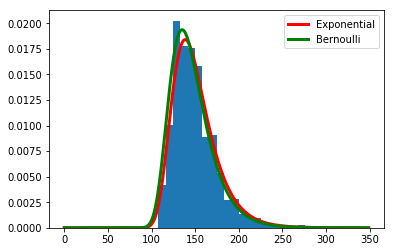

In [14]:
from scipy.stats import poisson
(n, bins, _) = hist(Ts, bins=20, density=True)

t = arange(350)
mu = t/(tau+1.0)
p = 1/(tau+1.0)
N = V_init
P = N*(1-exp(-mu))**(N-1)*exp(-mu)*p
plot(t,P, 'r', linewidth=3, label="Exponential")

P = N*(1-(1-p)**t)**(N-1)*p*(1-p)**(t-1)
plot(t,P, 'g', linewidth=3, label="Bernoulli")
legend();

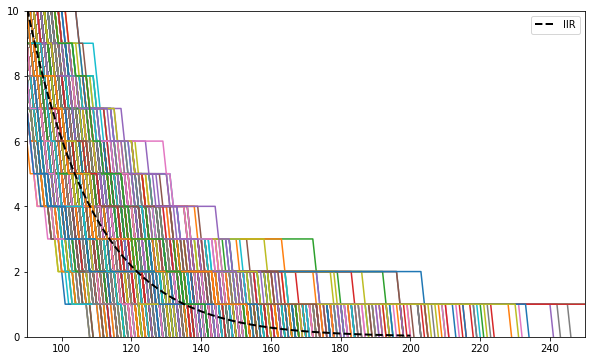

In [15]:
ax.set_xlim((90,250))
ax.set_ylim((0,10))
ax.legend()
display(fig)

Compare the arrivals at $0$ with those from the radioactive decay. While the distribution of the survival times is the same, the distribution of arriving at other values of $V$ is quite different.

<img align="left" src="fig2.png">

<span style="color:red">The derivation above also does not take into account that for $V > \tau+1$ there is a deterministic part of the decay ($int(V/(\tau+1)$), but the simulation started with $V = 1023$ and $\tau = 19$ and thus had significant deterministic decay. It doesn't seem to affect the final fit. I still need to work this out.</span>

# Implementation

The above version needs to multiply $V$ by the IIR constant $a$ and then split the result into an integer part and a fractional part and then compare the random number with the fractional part. This is slightly more complex than needed in hardware, and a simpler implementation of the above scheme can made if we simply add a uniform random, $r$ (in the interval $[0,1)$) to $aV$ and only store the integer part of this sum. The math works out the same: 

$$\begin{align*}
V[t+1] &= int\left(\frac{\tau}{\tau+1}V[t] + r[t]\right)\\
\\
d &= V[t] - V[t+1] \\
&= V[t] - int\left(\frac{\tau}{\tau+1}V[t] + r[t]\right) \\
&= int(V[t]) - int\left(V[t] - \frac{V[t]}{\tau+1} + r[t]\right) \\
&= -int\left(r[t]-\frac{V[t]}{\tau+1}\right) \\
&= int(\frac{V[t]}{\tau+1}) + X 
\end{align*}$$

where $X$ is a binary random variable with:

$$ P(X=1) = P(r > 1 - \frac{V[t]}{\tau+1}\%1) = \frac{V[t]}{\tau+1}\%1 $$

In an actual implementation, $r$ is typically generated as a pseudorandom number using a Linear Feedback Shift Register, which means that $r$ cannot be $0$, and instead has a uniform random distribution in the interval $(0,1)$. This will have a very minor effect on the decay when the number of bits to code $r$ is large.

In our example below $V$ is stored as a 4-bit integer, $r$ is a 10-bit random fraction, and $a$ is also stored as a 10-bit fraction. We are multiplying a 4-bit number with a 10-bit number, adding a 10-bit number, and storing only the 4 MSBs of the 14-bit result. In this example, tau is changed from the default (19) we have used above to a shorter time constant (3), just to show something different.

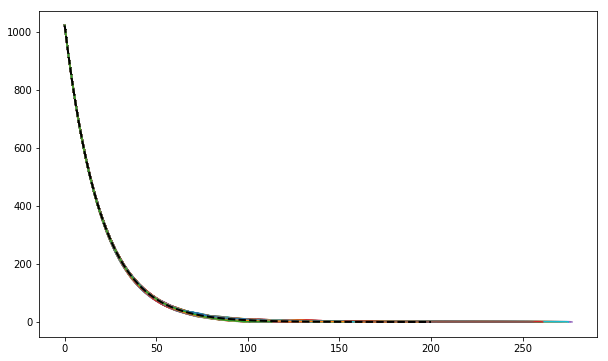

In [9]:
def LFSR_10bit (lfsr_i):
        lfsr_o = roll(lfsr_i,1)
        lfsr_o[3] = lfsr_o[3]^lfsr_o[0]
        return lfsr_o


def stochastic_decay(V_init = 15, tau = 19, seed = 123, V_bits = 4):
    # stochastic decay from V_init (integer)
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    V_int = V_init                              # reset initial voltage
    Vs = V_int                                  # store V_int in trace for plotting
    t = 0                                       # initialise decay time counter

    while ( V_int > 0 ):                        # decay full trace for this seed
        lfsr = LFSR_10bit(lfsr)                 # generate the random fraction
        r = bin2dec(10,lfsr)/2.**10
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        V_int = int(V_int*a+r)                  # add random fraction and multiply with IIR factor
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
        Vs = append(Vs,V_int)                   # append V_int to trace
        t += 1                                  # increment decay time counter

    return Vs, t                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
V_init = 1023                                   # initial value
Ti = []                                         # empty array to store decay times
for seed in range(1,1024):                      # try all possible random seeds for lfsr
    (Vs,t) = stochastic_decay(V_init, tau, seed, V_bits=10)
    Ti = append(Ti,t)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a                                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

_ = plot(Vd,'k--', linewidth=2, label='IIR')        # plot IIR trace (once)


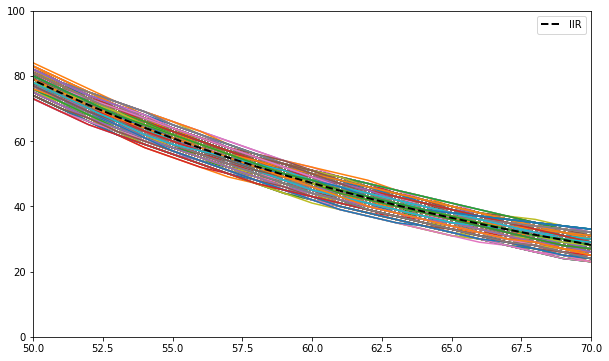

In [17]:
ax.set_xlim((50,70))
ax.set_ylim((0,100))
ax.legend()
display(fig)

Using only 10-bit pseudorandom numbers from an LFSR means that all 1023 possible seeds for the decay curve have been exhausted in this simulation. This limited randomness influences the distribution of the survival times, as shown below. We can easily use longer LFSRs to create better random numbers.

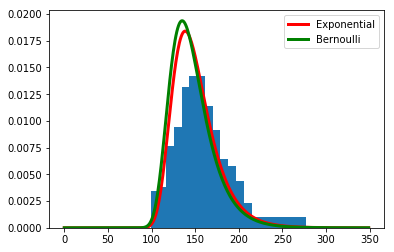

In [18]:
(n, bins, _) = hist(Ti, bins=20, density=True)

t = arange(350)
mu = t/(tau+1.0)
p = 1/(tau+1.0)
N = V_init
P = N*(1-exp(-mu))**(N-1)*exp(-mu)*p
plot(t,P, 'r', linewidth=3, label="Exponential")

P = N*(1-(1-p)**t)**(N-1)*p*(1-p)**(t-1)
plot(t,P, 'g', linewidth=3, label="Bernoulli")

_ = legend()

# Low-Pass Filter

We can also apply this method to create a low-pass filter. The IIR equation for a first order low-pass filter is:

$$ V[t] = a V[t-1] + (1-a) V_{in} $$

Just as we stochastically decide to decay with probability $p=a$, we could decide to stochastically add $V_{in}$ to $V$ with probability $p=(1-a)$. However, since $(1-a)$ is typically close to 0, this would effectively result in severely reducing the sampling rate of the input signal. A better solution is found by rewriting the filter equation as:

$$ V[t] = a (V[t-1] - V_{in}) + V_{in} $$

In this case, every sample of $V_{in}$ is used. Note that now, even if $V$ and $V_{in}$ are unsigned integers, the term in brackets will be negative when $V < V_{in}$, and the multiplier will need to be able to handle this.

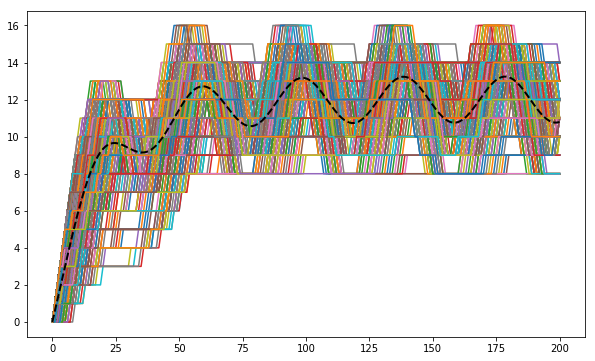

In [19]:
def V_in(t):
    V = 12 + 4*sin(2*pi*t/40)                 # Input signal is a sine wave plus offset
    return V

def LPF(V_init = 0, tau = 19, seed = 123, V_bits = 4, dur = 200):
    # stochastic LPF from V_init (integer)
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_init)              # convert to binary
    V_int = V_init                              # reset initial voltage
    Vs = V_int                                  # store V_int in trace for plotting

    for t in range(dur):                        # simulate dur time steps
        lfsr = LFSR_10bit(lfsr)                 # clock the shift register
        r = bin2dec(10,lfsr)/2.**10             # generate the random fraction
        V_int = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vin = V_in(t)                           # read filter input
        V_int = int((V_int-Vin)*a + Vin + r)    # LPF equation
        V_bin = dec2bin(V_bits ,V_int)          # convert back to binary (4 bits)
        Vs = append(Vs,V_int)                   # append V_int to  trace

    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
tau = 19                                        # time constant in units of dt
a = tau/(tau+1.0)                               # IIR multiplication constant
V_init = 0                                      # initial value
for seed in range(1,1023):                      # try all possible random seeds for lfsr
    Vs = LPF(V_init, tau, seed, V_bits=10)
    plot(Vs)
    
Vd = V_init                                     # IIR decay trace
V = V_init                                      # IIR initial value
for t in range(200):
        V = V*a + V_in(t)*(1-a)                 # IIR decay
        Vd = append(Vd,V)                       # append to trace

_ = plot(Vd,'k--', linewidth=2, label='IIR')        # plot IIR trace (once)


# Leaky-Integrate-and-Fire Neuron

As mentioned at the start, we are really interested in implementing these stochastic decays on FPGA in order to build networks of millions of neurons running in real time. A **Leaky-Integrate-and-Fire** (LIF) neuron is normally implemented as a first order IIR filter for the membrane voltage. When the membrane voltage reaches a certain threshold, an action potential (spike) is fired and the membrane potential is reset.

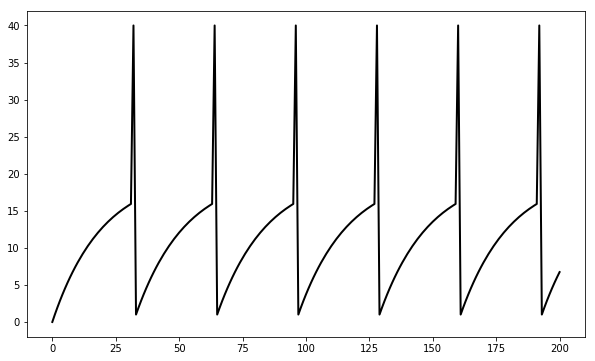

In [6]:
def V_in(t):
    V = 20                                      # constant input
    return V

def LIF(V_reset = 0, V_thres = 16, tau = 19, dur = 200):
    # LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting

    for t in range(dur):                        # simulate dur time steps
        V_mem = a*V_mem + (1-a)*V_in(t)         # LPF equation
        Vs = append(Vs,V_mem)                   # append V_mem to trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike

    return Vs                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
Vs = LIF(V_reset = 0, V_thres = 16, tau = 19, dur = 200)
_ = plot(Vs,'k', linewidth=2)

Note that with a constant input, and without any noise explicitly added to the system, the spike train is perfectly regular. In other words, the **Inter-Spike Interval** (ISI) is constant. The time between spikes is calculated as:

$$\begin{align*}
V_{mem}(t) &= (1-e^{-t/\tau})V_{in} = V_{thres}\\
e^{-t/\tau} &= 1 - \frac{V_{thres}}{V_{in}}\\
t &= -\tau\; ln(1-\frac{V_{thres}}{V_{in}})
\end{align*}$$

So in the example above it takes 31 time-steps to cross threshold and the ISI is 31.

In [19]:
V_thres = 16; tau = 19
t = -tau*log(1.0-1.0*V_thres/V_in(0))
print(t)

30.57932033624791


A simple modification to add randomness to a LIF neuron is to add Gaussian white noise ($\xi$):

$$
\tau\frac{dV_{mem}}{dt} = -V_{mem} + V_{in} + \xi
$$

which turns the equation into an Ornstein-Uhlenbeck process. No analytical solution to the resulting ISI distribution is known, but we can simulate it instead.

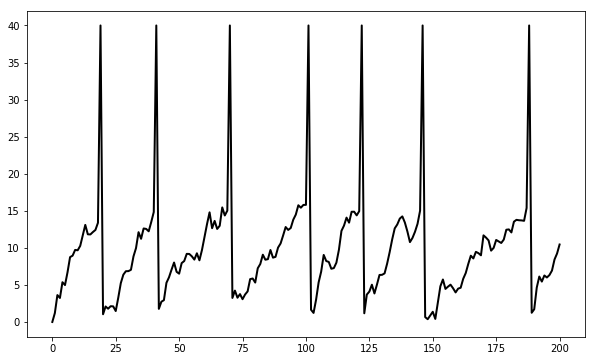

In [7]:
def LIFn(V_reset = 0, V_thres = 16, tau = 19, dur = 200):
    # LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting
    ST = []

    for t in range(dur):                        # simulate dur time steps
        V_mem = a*V_mem + (1-a)*V_in(t)         # LPF equation
        V_mem += randn()                        # additive Gaussian (Normal) noise
        Vs = append(Vs,V_mem)                   # append V_mem to trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike
            ST = append(ST,t)                   # record spike time

    return Vs, ST                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
(Vs, ST) = LIFn()
_ = plot(Vs,'k', linewidth=2, label='IIR')


Now the spike intervals have a random component to them. If we collect statistics over many more spikes (by simulating for a longer time) and plot the histogram of the ISIs, we get something that looks very much like an exponential distribution:

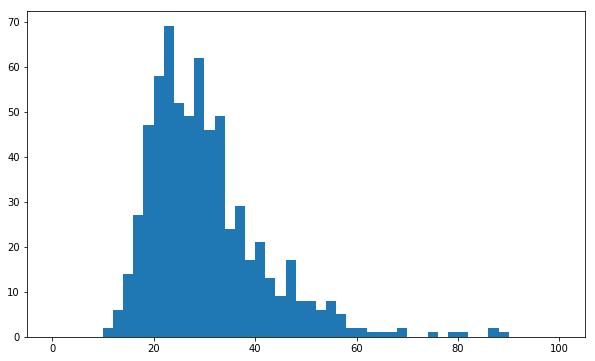

In [21]:
(Vs, ST) = LIFn(dur = 20000)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,6)
ax = subplot(1,1,1)
_ = hist(ISI, bins=50, range=(0,100))

<span style="color:red">What is the exact description of this distribution? I expect inverse Gaussian, but I don't know for sure. To do.</span>

By applying stochastic decay instead of adding noise to the membrane voltage, we get a different ISI distribution.

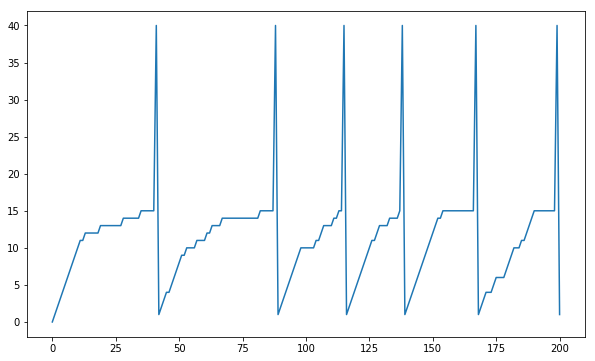

In [10]:
def V_in(t):
    V = 20                                      # constant input
    return V

def SLIF(V_reset = 0, V_thres = 16, tau = 19, seed = 123, V_bits = 4, dur = 200):
    # stochastic LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_10bit(dec2bin(10,seed))         # load seed
    V_bin = dec2bin(V_bits,V_reset)             # convert to binary
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting
    ST = []                                     # list of spike times

    for t in range(dur):                        # simulate dur time steps
        lfsr = LFSR_10bit(lfsr)                 # clock the shift register
        r = bin2dec(10,lfsr)/2.**10             # generate the random fraction
        V_mem = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vin = V_in(t)                           # read filter input
        V_mem = int((V_mem-Vin)*a + Vin + r)    # LPF equation
        Vs = append(Vs,V_mem)                   # append V_mem to  trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike
            ST = append(ST,t)                   # record spike time
        V_bin = dec2bin(V_bits ,V_mem)          # convert back to binary (4 bits)

    return Vs, ST                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
Vs, ST = SLIF()
_ = plot(Vs)   


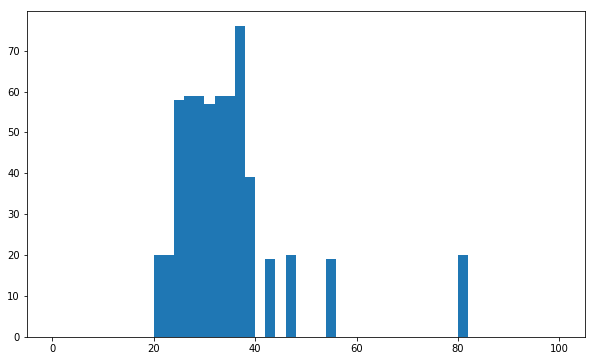

In [23]:
(Vs, ST) = SLIF(dur = 20000)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,6)
ax = subplot(1,1,1)
_ = hist(ISI, bins=50, range=(0,100))

(_Pablo_) Use the code below.

The strange shape of this distibution, with gaps and clusters, due to the generation of the (pseudo)random number (uniformly distributed between 0 and 1) with an LFSR of only 10 bits, which is periodic in 1023 cycles. If we use a 20-bit LFSR instead, we get:

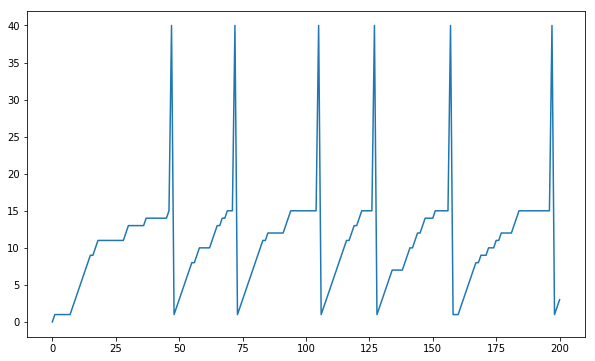

In [11]:
def V_in(t):
    V = 20                                      # constant input
    return V

def LFSR_20bit (lfsr_i):
        lfsr_o = roll(lfsr_i,1)
        lfsr_o[3] = lfsr_o[3]^lfsr_o[0]
        return lfsr_o

def SLIF(V_reset = 0, V_thres = 16, tau = 19, seed = 123, V_bits = 4, dur = 200):
    # stochastic LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    lfsr = LFSR_20bit(dec2bin(20,seed))         # load seed
    V_bin = dec2bin(V_bits,V_reset)             # convert to binary
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting
    ST = []                                     # list of spike times

    for t in range(dur):                        # simulate dur time steps
        lfsr = LFSR_20bit(lfsr)                 # clock the shift register
        r = bin2dec(20,lfsr)/2.**20             # generate the random fraction
        V_mem = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vin = V_in(t)                           # read filter input
        V_mem = int((V_mem-Vin)*a + Vin + r)    # LPF equation
        Vs = append(Vs,V_mem)                   # append V_mem to  trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike
            ST = append(ST,t)                   # record spike time
        V_bin = dec2bin(V_bits ,V_mem)          # convert back to binary (4 bits)

    return Vs, ST                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
Vs, ST = SLIF()
_ = plot(Vs)   


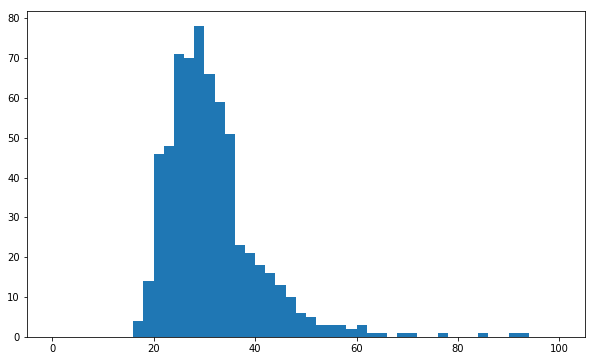

In [25]:
(Vs, ST) = SLIF(dur = 20000)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,6)
ax = subplot(1,1,1)
_ = hist(ISI, bins=50, range=(0,100))

This distribution looks much better. In fact, it looks quite a bit like a Poisson distribution with a mean spike interval of 31.

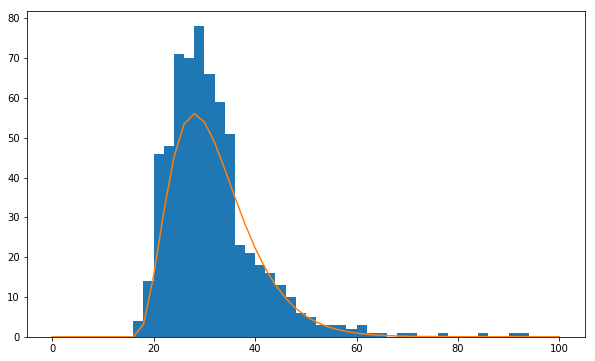

In [26]:
from scipy.stats import gamma

fig = figure()
fig.set_size_inches(10,6)
ax = subplot(1,1,1)
(n, bins, _) = hist(ISI, bins=50, range=(0,100))

_= plot(bins, 1000*gamma.pdf(bins, 4, scale=4, loc=16))

Or maybe not! <span style="color:red">I need to work out what this is, but don't want to get stuck in the pseudorandom LFSR numbers. Instead we'll use a much larger LFSR and only use 10 bits of it to get much better randomness. Skip to the version that uses the rand() function below.</span>

Above, we collect statistics starting with a single random seed (123). With a different seed (1234) we get:

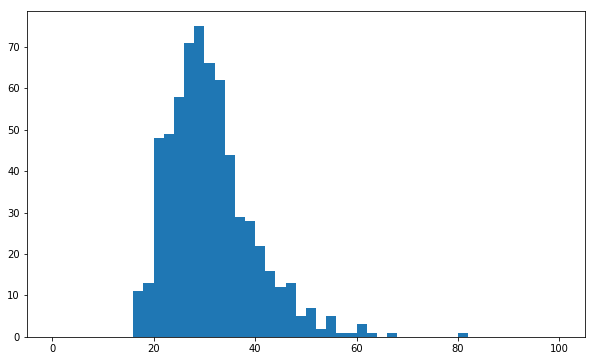

In [27]:
(Vs, ST) = SLIF(dur = 20000, seed = 1234)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,6)
ax = subplot(1,1,1)
(n, bins, _) = hist(ISI, bins=50, range=(0,100))

If we use Python's random number generator (the rand() function), we get a similar, but slightly narrower looking distribution:

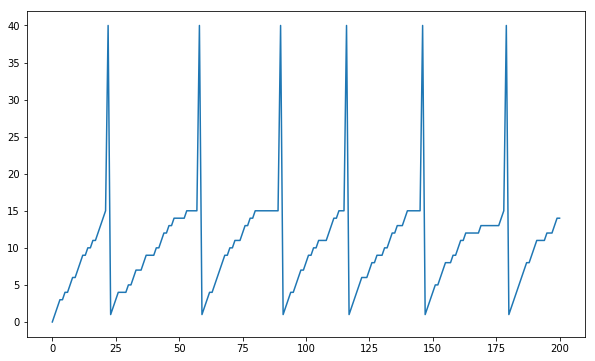

In [28]:
def V_in(t):
    V = 20                                      # constant input
    return V

def SLIFrand(V_reset = 0, V_thres = 16, tau = 19, V_bits = 4, dur = 200):
    # stochastic LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    V_bin = dec2bin(V_bits,V_reset)             # convert to binary
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting
    ST = []                                     # list of spike times

    for t in range(dur):                        # simulate dur time steps
        r = rand()                              # generate the random fraction
        V_mem = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vin = V_in(t)                           # read filter input
        V_mem = int((V_mem-Vin)*a + Vin + r)    # LPF equation
        Vs = append(Vs,V_mem)                   # append V_mem to  trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike
            ST = append(ST,t)                   # record spike time
        V_bin = dec2bin(V_bits ,V_mem)          # convert back to binary (4 bits)

    return Vs, ST                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
Vs, ST = SLIFrand()
_ = plot(Vs)   


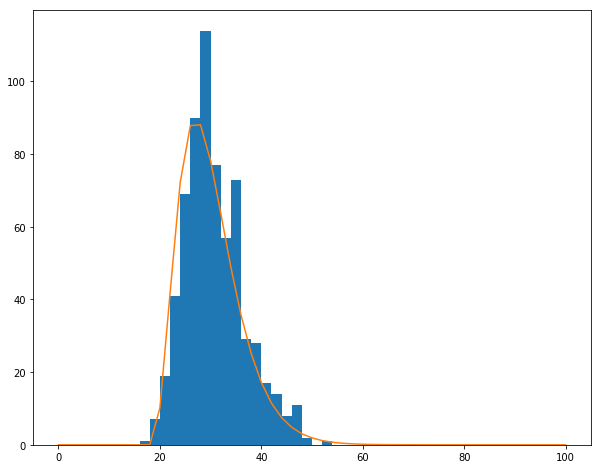

In [29]:
(Vs, ST) = SLIFrand(dur = 20000)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,8)
ax = subplot(1,1,1)
_ = hist(ISI, bins=50, range=(0,100))
_= plot(bins, 1200*gamma.pdf(bins, 4, scale=3, loc=18))

<span style="color:red">We can get a reasonable fit with a gamma distribution here (and probably do better if we regress the shape parameters rather than just pick them on what looks OK, as I have done now) but it would be nice to get an analytic solution to this distribution.</span>

We can use the radioactive decay approach to create our neuron instead.

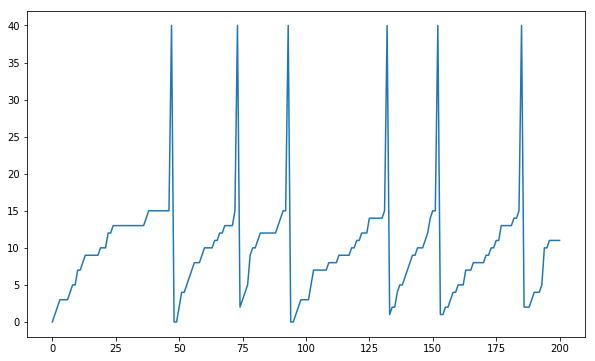

In [30]:
def V_in(t):
    V = 20                                      # constant input
    return V

def SLIF_ra(V_reset = 0, V_thres = 16, tau = 19, V_bits = 4, dur = 200):
    # stochastic LIF neuron
    # tau is the time constant in units of dt (integer)

    # initialisation
    a = tau/(tau+1.0)
    V_bin = dec2bin(V_bits,V_reset)             # convert to binary
    V_mem = V_reset                             # reset initial voltage
    Vs = V_mem                                  # store V_int in trace for plotting
    ST = []                                     # list of spike times

    for t in range(dur):                        # simulate dur time steps
        V_mem = bin2dec(V_bits, V_bin)          # convert binary stored state to integer
        Vin = V_in(t)                           # read filter input
        r = rand(Vin-V_mem)                     # generate random numbers
        i = sum(r>=a)                           # determine how many increment
        V_mem = int(V_mem+i)                    # LPF equation
        Vs = append(Vs,V_mem)                   # append V_mem to  trace
        if V_mem >= V_thres:                    # check if V_mem > threshold
            V_mem = V_reset                     # reset V_mem
            Vs[-1] = 40                         # plot spike
            ST = append(ST,t)                   # record spike time
        V_bin = dec2bin(V_bits ,V_mem)          # convert back to binary (4 bits)

    return Vs, ST                                

fig = figure()
fig.set_size_inches(10,6)
ax= subplot(1,1,1)
Vs, ST = SLIF_ra()
_ = plot(Vs)   


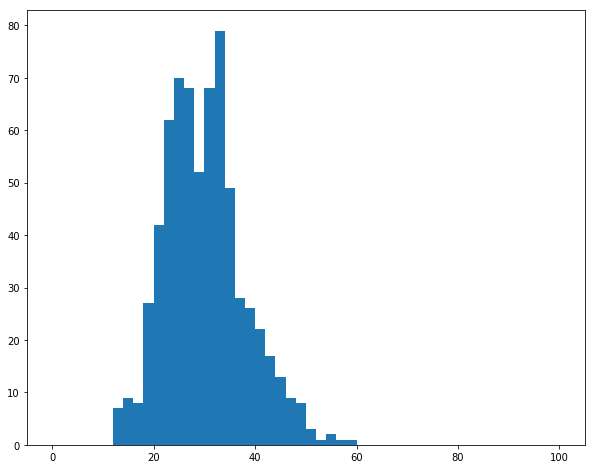

In [31]:
(Vs, ST) = SLIF_ra(dur = 20000)
ISI = ST[1:-1] - ST[0:-2]

fig = figure()
fig.set_size_inches(10,8)
ax = subplot(1,1,1)
_ = hist(ISI, bins=50, range=(0,100))


<span style="color:red">As expected, this distribution looks wider. As shown in the decay case above, the survival time for decay to $0$ is the same in both version of stochastic decay, but the distribution for the radioacive decay case is much wider at intermediate values. The neuron threshold here (16) is an intermediate value of the terminal value of the low-pass filter case ($V_in = 20$)</span>